**Atenção! Essa aula foi feita para ser executada no [Google Colab](https://colab.research.google.com/)!**

---

# Aprendizado Profundo - UFMG

## Funções de Ativações

Como falado anteriormente, uma parte importante na criação da arquitetura da rede neural é a definição da função de ativação.
Várias funções foram propostas ao longo do tempo entre elas [tangente hiperbólica (tanh)](https://mxnet.incubator.apache.org/api/python/symbol/symbol.html#mxnet.symbol.Symbol.tanh), [sigmóide](https://mxnet.incubator.apache.org/api/python/symbol/symbol.html#mxnet.symbol.Symbol.sigmoid),  e [ReLU](https://mxnet.incubator.apache.org/api/python/symbol/symbol.html#mxnet.symbol.Symbol.relu).


Neste *notebook*, veremos qual formato, vantagens, e desvantagens das diferentes funções de ativações.
Veremos, também, como usar essas funções no *framework* MXNet.


Antes de começar, vamos instalar o MXNet. Esse pequeno bloco de código abaixo é usado somente para instalar o MXNet para CUDA 10. Execute esse bloco somente uma vez e ignore possíveis erros levantados durante a instalação.

**ATENÇÃO: a alteração dos blocos abaixo pode implicar em problemas na execução dos blocos restantes!**

## Preâmbulo

In [1]:
# !pip install mxnet-cu100

In [2]:
from mxnet import autograd
from mxnet import gluon
from mxnet import init
from mxnet import nd

from mxnet.gluon import data as gdata
from mxnet.gluon import loss as gloss
from mxnet.gluon import nn
from mxnet.gluon import utils as gutils

import mxnet as mx
import numpy as np

import os
import sys
import time

In [3]:
import matplotlib.pyplot as plt
plt.ion()

In [4]:
# Tenta encontrar GPU
def try_gpu():
    try:
        ctx = mx.gpu()
        _ = nd.zeros((1,), ctx=ctx)
    except mx.base.MXNetError:
        ctx = mx.cpu()
    return ctx

# CTX é um contexto mxnet, caso exista GPU o código rola nela. Caso não, executa na CPU mesmo.
ctx = try_gpu()
ctx

cpu(0)

## Binária

Uma das primeiras e mais função de ativação é a binária.
Ela foi proposta e muito usada no início das redes neurais.
Entretanto, posteriormente, ela foi substituída por outras ativações mais modernas que veremos a seguir.
Tecnicamente, esta função produz 1 (ou verdadeiro) quando a entrada ultrapassa um limite $\theta$, enquanto produz 0 (ou falso) quando a entrada não ultrapassa esse limite.

Formalmente, dada uma entrada $x$, a saída $y$ será calculada da seguinte forma:

$$
y =
\begin{cases}
1, \text{if}~x>\theta \\
0, \text{caso contrário}
\end{cases}
$$

A grande vantagem dessa ativação é a sua simplicidade.
Por outro lado, sua grande desvantagem é que ela não derivada análitica para ser usada junto com o algoritmo de *backpropgagtion*.

Abaixo, um código que implementa essa função do zero e faz um gráfico para auxiliar na visualização desta ativação.

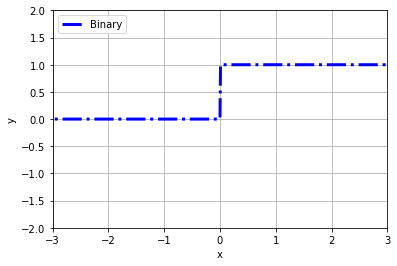

In [5]:
def binary_activation(x, theta=0):
    a = []
    for item in x:
        if item <= theta:
            a.append(0)
        elif item > theta:
            a.append(1)
    return a

ax = plt.subplot()
ax.yaxis.grid()
ax.xaxis.grid()
ax.set_ylabel('y')
ax.set_xlabel('x')

x = np.arange(-4., 4., 0.01)
binary = binary_activation(x)

binaryPlot = plt.plot(x, binary, label='Binary', ls='-.', lw=3, color='blue')

plt.legend(loc=2)
plt.ylim([-2, 2])
plt.xlim([-3, 3])
plt.show()

## Sigmóide

Como manter a vantagem da função binária e ao mesmo tempo resolver seu problema de derivada?
Neste caso, temos a função de ativação chamada [sigmóide](https://mxnet.incubator.apache.org/api/python/symbol/symbol.html#mxnet.symbol.Symbol.sigmoid). 
Essa função não-linear tem um formato similar ao da função binária, porém tem um gradiente suave, já que é definida em toda seu domínio.

Formalmente, dada uma entrada $x$, a saída $y$ será calculada da seguinte forma:

$$y=\frac{1}{(1+exp^{(−x)})}$$

Note que para valores de entrada entre -2 a 2, os valores de saída são muito diferentes.
Isso significa que quaisquer pequenas alterações nos valores de $x$ nessa região farão com que os valores de $y$ sejam alterados significativamente.
Dessa forma, essa função tem a tendência de trazer os valores de $y$ para qualquer extremidade da curva.
Outra característica dessa função é que ela também terá a saída limitada no intervalo $(0,1)$.

A grande desvantagem dessa função é que o gradiente em suas extremidades será pequeno, já que são poucas mudanças (ou seja, a função se estabiliza e forma quase uma reta).
Nesses casos, o gradiente fica tão pequeno que "desaparece" (problema conhecido como *vanishing gradients*), ou seja, não tem impacto efetivo devido ao valor extremamente pequeno.
Esse problema faz com que a rede não aprenda mais ou aprenda drasticamente lenta.
Existem maneiras de contornar esse problema que veremos a seguir.

Abaixo, um código que implementa essa função do zero e faz um gráfico para auxiliar na visualização desta ativação.

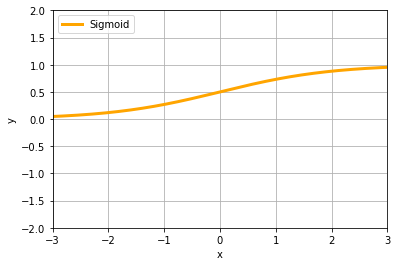

In [6]:
def sigmoid(x):
    a = []
    for item in x:
        a.append(1 / (1 + np.exp(-item)))
    return a
  
ax = plt.subplot()
ax.yaxis.grid()
ax.xaxis.grid()
ax.set_ylabel('y')
ax.set_xlabel('x')

x = np.arange(-4., 4., 0.01)
sig = sigmoid(x)

sigmoidPlot = plt.plot(x, sig, label='Sigmoid', ls='solid', lw=3, color='orange')

plt.legend(loc=2)
plt.ylim([-2, 2])
plt.xlim([-3, 3])
plt.show()

## Tangente Hiperbólica

Uma outra função de ativação muito difundida com características semelhantes à sigmóide é a [tangente hiperbólica (tanh)](https://mxnet.incubator.apache.org/api/python/symbol/symbol.html#mxnet.symbol.Symbol.tanh). 
Essa função não linear, limitada no intervalo $(-1, 1)$, tem o gradiente mais significativo do que para a função sigmóide.
Decidir entre o sigmóide ou o tanh dependerá da sua exigência em relação ao gradiente.
Como o sigmóide, o tanh também tem, mas em menor intensidade, o problema de *vanishing gradients*.

Formalmente, dada uma entrada $x$, a saída $y$ será calculada da seguinte forma:

$$y=\frac{2}{(1+exp^{(−2x)})} -1$$

O Tanh também é uma função de ativação muito popular e amplamente utilizada.

Abaixo, um código que implementa essa função do zero e faz um gráfico para auxiliar na visualização desta ativação.

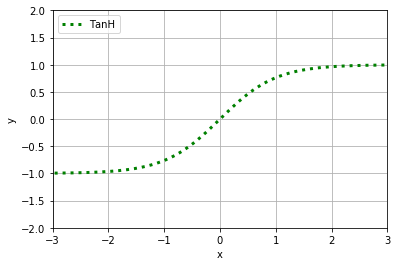

In [7]:
def tanh(x):
    a = []
    for item in x:
        a.append((2 / (1 + np.exp(-2*item))-1))
    return a
  
ax = plt.subplot()
ax.yaxis.grid()
ax.xaxis.grid()
ax.set_ylabel('y')
ax.set_xlabel('x')

x = np.arange(-4., 4., 0.01)
th = tanh(x)

tanhPlot = plt.plot(x, th, label='TanH', ls='dotted', lw=3, color='green')

plt.legend(loc=2)
plt.ylim([-2, 2])
plt.xlim([-3, 3])
plt.show()

## ReLU

Uma última função de ativação mais moderna é a chamada [ReLU](https://mxnet.incubator.apache.org/api/python/symbol/symbol.html#mxnet.symbol.Symbol.relu). 

Formalmente, dada uma entrada $x$, a saída $y$ será calculada da seguinte forma:

$$y=\max(0, x)$$

Essa função não-linear tem intervalo $[0, +\infty]$, o que significa que pode haver um problema chamado de explosão da ativação (quando o valor da ativação fica mto alto e anula as outras ativações).

Uma vantagem dessa ativação é permitir a esparcidade das ativações, ou seja, que haja neurônios desativados (com ativações zero).
Isso torna as ativações escassas e força com que elas fiquem mais eficientes.
Por outro lado, a desvantagem é que neurônio com valores negativos são desligados e não são mais reativados, já que o gradiente para valores negativos é zero.
Esse problema, chamado *dying ReLu problem*, faz com que vários neurônios simplesmente morram e não respondam tornando uma parte substancial da rede passiva.
Existem variações no ReLu para atenuar esse problema simplesmente manuseando valores negativos ligeiramente diferentes.
Por fim, ReLu é menos computacionalmente caro do que tanh e sigmoid porque envolve operações matemáticas mais simples.
Esse é um bom ponto a considerar quando estamos projetando redes neurais profundas.

Abaixo, um código que implementa essa função do zero e faz um gráfico para auxiliar na visualização desta ativação.



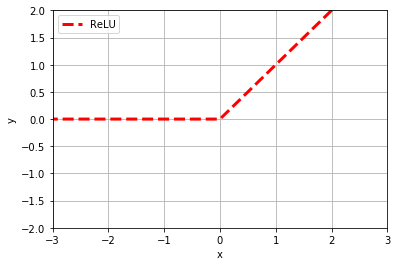

In [8]:
def reluFunc(x):
    a = []
    for item in x:
        if item <= 0.0:
            a.append(0)
        else:
            a.append(item)
    return a
  
ax = plt.subplot()
ax.yaxis.grid()
ax.xaxis.grid()
ax.set_ylabel('y')
ax.set_xlabel('x')

x = np.arange(-4., 4., 0.01)
relu = reluFunc(x)

reluPlot = plt.plot(x, relu, label='ReLU', ls='dashed', lw=3, color='red')

plt.legend(loc=2)
plt.ylim([-2, 2])
plt.xlim([-3, 3])
plt.show()

## Comparação

O gráfico abaixo mostra todas as funções de ativação vistas acima juntas.
Reparem na diferença das ativações.
Obviamente, algumas ativações são melhores para alguns casos enquanto outras são mais usadas em outros cenários.
Depende diretamente do pesquisador testar e selecionar qual melhor função de ativação para o problema em questão.

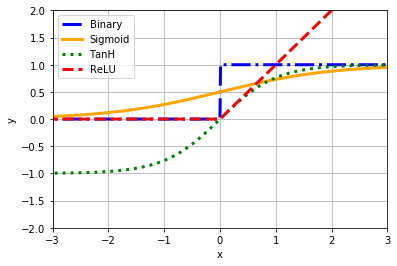

In [9]:
ax = plt.subplot()
ax.yaxis.grid()
ax.xaxis.grid()
ax.set_ylabel('y')
ax.set_xlabel('x')

x = np.arange(-4., 4., 0.01)
binary = binary_activation(x)
sig = sigmoid(x)
th = tanh(x)
relu = reluFunc(x)

binaryPlot = plt.plot(x, binary, label='Binary', ls='-.', lw=3, color='blue')
sigmoidPlot = plt.plot(x, sig, label='Sigmoid', ls='solid', lw=3, color='orange')
tanhPlot = plt.plot(x, th, label='TanH', ls='dotted', lw=3, color='green')
reluPlot = plt.plot(x, relu, label='ReLU', ls='dashed', lw=3, color='red')

plt.legend(loc=2)
plt.ylim([-2, 2])
plt.xlim([-3, 3])
plt.show()

# MXNet

Agora veremos como usar e implementar algumas dessas funções no *framework* MXNet.
Para isso, usamos o dataset [Fashion MNIST](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/), um dataset tradicional de reconhecimento de peças de roupas.
Além disso, usaremos uma rede MLP simples para testes.

In [10]:
# código para carregar o dataset do Fashion-MNIST
# https://github.com/zalandoresearch/fashion-mnist
def load_data_fashion_mnist(batch_size, resize=None, root=os.path.join(
        '~', '.mxnet', 'datasets', 'fashion-mnist')):
    """Download the Fashion-MNIST dataset and then load into memory."""
    root = os.path.expanduser(root)
    transformer = []
    if resize:
        transformer += [gdata.vision.transforms.Resize(resize)]
    transformer += [gdata.vision.transforms.ToTensor()]
    transformer = gdata.vision.transforms.Compose(transformer)

    mnist_train = gdata.vision.FashionMNIST(root=root, train=True)
    mnist_test = gdata.vision.FashionMNIST(root=root, train=False)
    num_workers = 0 if sys.platform.startswith('win32') else 4

    train_iter = gdata.DataLoader(mnist_train.transform_first(transformer),
                                  batch_size, shuffle=True,
                                  num_workers=num_workers)
    test_iter = gdata.DataLoader(mnist_test.transform_first(transformer),
                                 batch_size, shuffle=False,
                                 num_workers=num_workers)
    return train_iter, test_iter

In [11]:
# funções básicas
def _get_batch(batch, ctx):
    """Return features and labels on ctx."""
    features, labels = batch
    if labels.dtype != features.dtype:
        labels = labels.astype(features.dtype)
    return (gutils.split_and_load(features, ctx),
            gutils.split_and_load(labels, ctx), features.shape[0])

# Função usada para calcular acurácia
def evaluate_accuracy(data_iter, net, loss, ctx=[mx.cpu()]):
    """Evaluate accuracy of a model on the given data set."""
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    acc_sum, n, l = nd.array([0]), 0, 0
    for batch in data_iter:
        features, labels, _ = _get_batch(batch, ctx)
        for X, y in zip(features, labels):
            # X, y = X.as_in_context(ctx), y.as_in_context(ctx)
            y = y.astype('float32')
            y_hat = net(X)
            l += loss(y_hat, y).sum()
            acc_sum += (y_hat.argmax(axis=1) == y).sum().copyto(mx.cpu())
            n += y.size
        acc_sum.wait_to_read()
    return acc_sum.asscalar() / n, l.asscalar() / n
  
# Função usada no treinamento e validação da rede
def train_validate(net, train_iter, test_iter, batch_size, trainer, loss, ctx,
                   num_epochs):
    print('training on', ctx)
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X, y = X.as_in_context(ctx), y.as_in_context(ctx)
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum()
            l.backward()
            trainer.step(batch_size)
            y = y.astype('float32')
            train_l_sum += l.asscalar()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().asscalar()
            n += y.size
        test_acc, test_loss = evaluate_accuracy(test_iter, net, loss, ctx)
        print('epoch %d, train loss %.4f, train acc %.3f, test loss %.4f, '
              'test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_loss, 
                 test_acc, time.time() - start))

## Sigmóide

Num geral, para implementar um camada usando a ativação, basta adicionar o parâmetro *activation* e passar como argumento a ativação desejada.
Logo, para implementar um camada usando a ativação [sigmóide](https://mxnet.incubator.apache.org/api/python/symbol/symbol.html#mxnet.symbol.Symbol.sigmoid), basta adicionar o parâmetro *activation* e 'relu' como argumento, como mostrado no exemplo abaixo.

In [12]:
# parâmetros: número de epochs, learning rate (ou taxa de aprendizado), e 
# tamanho do batch
num_epochs, lr, batch_size = 10, 0.5, 256

# rede simples somente com perceptrons e camadas densamente conectadas
net = nn.Sequential()
net.add(nn.Dense(256, activation="sigmoid"),
        nn.Dense(128, activation="sigmoid"),
        nn.Dense(64, activation="sigmoid"),
        nn.Dense(10))
net.initialize(init.Normal(sigma=0.01), ctx=ctx)

# função de custo (ou loss)
loss = gloss.SoftmaxCrossEntropyLoss()

# carregamento do dado: fashion mnist
train_iter, test_iter = load_data_fashion_mnist(batch_size)

# trainer do gluon
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})

# treinamento e validação via MXNet
train_validate(net, train_iter, test_iter, batch_size, trainer, loss, 
               ctx, num_epochs)

training on cpu(0)
epoch 1, train loss 2.3107, train acc 0.100, test loss 2.3073, test acc 0.100, time 4.8 sec
epoch 2, train loss 2.3073, train acc 0.100, test loss 2.3051, test acc 0.100, time 4.0 sec
epoch 3, train loss 2.3052, train acc 0.102, test loss 2.3036, test acc 0.100, time 4.1 sec
epoch 4, train loss 2.3045, train acc 0.099, test loss 2.3046, test acc 0.100, time 3.7 sec
epoch 5, train loss 2.3042, train acc 0.101, test loss 2.3049, test acc 0.100, time 4.0 sec
epoch 6, train loss 2.3038, train acc 0.099, test loss 2.3036, test acc 0.100, time 4.3 sec
epoch 7, train loss 2.3030, train acc 0.099, test loss 2.3027, test acc 0.209, time 4.5 sec
epoch 8, train loss 2.2990, train acc 0.122, test loss 2.2916, test acc 0.203, time 4.0 sec
epoch 9, train loss 2.2560, train acc 0.167, test loss 2.1435, test acc 0.195, time 4.1 sec
epoch 10, train loss 1.8064, train acc 0.243, test loss 1.6537, test acc 0.318, time 3.8 sec


## TanH, ReLU e outras

Agora é com você!
Estude e implemente outras arquiteturas com diferentes funções de ativações como [tangente hiperbólica (tanh)](https://mxnet.incubator.apache.org/api/python/symbol/symbol.html#mxnet.symbol.Symbol.tanh),  e [ReLU](https://mxnet.incubator.apache.org/api/python/symbol/symbol.html#mxnet.symbol.Symbol.relu).

Estude também outras funções de ativações mais recentes (como [LeakyReLU](https://mxnet.incubator.apache.org/api/python/symbol/symbol.html#mxnet.symbol.LeakyReLU) e [suas derivadas, como eLU e SeLU](https://arxiv.org/pdf/1804.02763.pdf)) e tente implementá-las usando o *framework* MXNet.
Neste caso, será necessário definir a arquitetura no formato de uma classe como neste [exemplo](https://gluon.mxnet.io/chapter03_deep-neural-networks/mlp-gluon.html#Define-the-model-with-gluon.Block).
